In [1]:
import argparse
import multiprocessing
import os
import pathlib
import shutil
import sys

import pandas as pd
import tqdm

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

if in_notebook:
    import tqdm.notebook as tqdm
else:
    import tqdm.tqdm as tqdm

    # Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Set paths and variables

In [2]:
argparse = argparse.ArgumentParser(
    description="Copy files from one directory to another"
)
argparse.add_argument("--HPC", action="store_true", help="Type of compute to run on")

# Parse arguments
args = argparse.parse_args(args=sys.argv[1:] if "ipykernel" not in sys.argv[0] else [])
HPC = args.HPC

print(f"HPC: {HPC}")

HPC: False


In [3]:
if HPC:
    raw_image_dir_hpc = pathlib.Path("/pl/active/koala/GFF_Data/GFF-Raw/").resolve(
        strict=True
    )
else:
    # comment out depending on whose computer you are on
    # mike's computer
    raw_image_dir_local = pathlib.Path(
        "~/Desktop/20TB_A/NF1_Patient_organoids/"
    ).resolve(strict=True)
    # Jenna's computer
    # raw_image_dir_local = pathlib.Path("/media/18tbdrive/GFF_organoid_data/")

In [4]:
# Define parent and destination directories in a single dictionary
dir_mapping = {
    "NF0014": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/NF0014-Thawed 3 (Raw image files)-Combined/NF0014-Thawed 3 (Raw image files)-Combined copy"
            if not HPC
            else f"{raw_image_dir_hpc}/NF0014-Thawed 3 (Raw image files)-Combined/NF0014-Thawed 3 (Raw image files)-Combined copy"
        ).resolve(strict=True),
    },
    "NF0016": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/NF0016 Cell Painting-Pilot Drug Screening-selected/NF0016-Cell Painting Images/NF0016-images copy"
            if not HPC
            else f"{raw_image_dir_hpc}/NF0016 Cell Painting-Pilot Drug Screening-selected/NF0016-Cell Painting Images/NF0016-images copy"
        ).resolve(strict=True),
    },
    # "NF0017": {
    #     "parent": pathlib.Path(
    #         f"{raw_image_dir_local}/NF0017-T3-P7 (AGP, Mito Parameter optimization)/Acquisition 03-07-2025"
    #         if not HPC
    #         else f"{raw_image_dir_hpc}/NF0017-T3-P7 (AGP, Mito Parameter optimization)/Acquisition 03-07-2025"  # TODO: Update this later if not correct
    #     ).resolve(strict=True),
    # },
    "NF0018": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/NF0018 (T6) Cell Painting-Pilot Drug Screeining/NF0018-Cell Painting Images/NF0018-All Acquisitions"
            if not HPC
            else f"{raw_image_dir_hpc}/NF0018 (T6) Cell Painting-Pilot Drug Screeining/NF0018-Cell Painting Images/NF0018-All Acquisitions"
        ).resolve(strict=True),
    },
    "NF0021": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/NF0021-T1/NF0021-T1 Combined"
            if not HPC
            else f"{raw_image_dir_hpc}/NF0021-T1/NF0021-T1 Combined"
        ).resolve(strict=True),
    },
    "NF0030": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/NF0030 Cell Painting/NF0030 Cell Painting/NF0030-Cell Painting Images/Combined"
            if not HPC
            else f"{raw_image_dir_hpc}/NF0030 Cell Painting/NF0030-Cell Painting Images/Combined"
        ).resolve(strict=True),
    },
    "NF0040": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/SARC0376 (NF0040) Cell Painting/SARC0376 (NF0040) Cell Painting/SARC0376 (NF0040)-Cell Painting Images/Combined"
            if not HPC
            else f"{raw_image_dir_hpc}/SARC0376 (NF0040) Cell Painting/SARC0376 (NF0040) Cell Painting/SARC0376 (NF0040)-Cell Painting Images/Combined"
        ).resolve(strict=True),
    },
    "SACRO219": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/SARC0219-T2 Cell Painting-selected/SARC0219-T2 Combined Cell Painting images/SARC0219-T2 Combined/"
            if not HPC
            else f"{raw_image_dir_hpc}/SARC0219-T2 Cell Painting-selected/SARC0219-T2 Combined Cell Painting images/SARC0219-T2 Combined/"
        ).resolve(strict=True),
    },
    "SARCO361": {
        "parent": pathlib.Path(
            f"{raw_image_dir_local}/SARC0361/SARC0361 Combined/"
            if not HPC
            else f"{raw_image_dir_hpc}/SARC0361/SARC0361 Combined/"
        ).resolve(strict=True),
    },
}

# Image extensions that we are looking to copy
image_extensions = {".tif", ".tiff"}

In [5]:
file_paths = {
    "patient": [],
    "file_path": [],
}

In [6]:
# Set channel names
channel_names = {"405", "488", "555", "640", "TRANS", "Merge"}

# Loop through each key in the mapping to copy data from the parent to the destination
for key, paths in dir_mapping.items():
    well_fovs = paths["parent"].glob("*")
    well_fovs = [x for x in well_fovs if x.is_dir()]
    for well_fov in tqdm.tqdm(well_fovs, desc=f"Processing {key} wells"):
        well_fov_name = well_fov.name
        well_fov_path = pathlib.Path(f"{well_fov}/{well_fov_name}/{well_fov_name}")
        well_fov_files = list(well_fov_path.glob("*"))
        well_fov_files = [
            x for x in well_fov_files if x.is_file() and x.suffix in image_extensions
        ]
        for file in well_fov_files:
            file_paths["patient"].append(key)
            file_paths["file_path"].append(file.resolve(strict=True))
file_info_df = pd.DataFrame(file_paths)

Processing NF0014 wells:   0%|          | 0/105 [00:00<?, ?it/s]

Processing NF0016 wells:   0%|          | 0/125 [00:00<?, ?it/s]

Processing NF0018 wells:   0%|          | 0/162 [00:00<?, ?it/s]

Processing NF0021 wells:   0%|          | 0/350 [00:00<?, ?it/s]

Processing NF0030 wells:   0%|          | 0/208 [00:00<?, ?it/s]

Processing NF0040 wells:   0%|          | 0/420 [00:00<?, ?it/s]

Processing SACRO219 wells:   0%|          | 0/199 [00:00<?, ?it/s]

Processing SARCO361 wells:   0%|          | 0/350 [00:00<?, ?it/s]

In [7]:
file_info_df["file_name"] = file_info_df["file_path"].apply(lambda x: x.stem)
file_info_df["well_fov"] = file_info_df["file_path"].apply(
    lambda x: x.stem.split("_")[0]
)
file_info_df["channel"] = file_info_df["file_name"].apply(lambda x: x.split("_")[1])
file_info_df["z_slice"] = file_info_df["file_name"].apply(lambda x: x.split("_")[2])
file_info_df["file_size_bytes"] = file_info_df["file_path"].apply(
    lambda x: x.stat().st_size
)
# drop row if Merge channel
file_info_df = file_info_df[~file_info_df["channel"].isin(["Merge"])]
file_info_df.head()

,patient,file_path,file_name,well_fov,channel,z_slice,file_size_bytes
0,NF0014,~/Desktop/20TB_A/NF1_Patient_orga...,D5-1_405_ZS006_FOV-1,D5-1,405,ZS006,5519777
1,NF0014,~/Desktop/20TB_A/NF1_Patient_orga...,D5-1_488_ZS010_FOV-1,D5-1,488,ZS010,5519777
3,NF0014,~/Desktop/20TB_A/NF1_Patient_orga...,D5-1_488_ZS001_FOV-1,D5-1,488,ZS001,5519777
4,NF0014,~/Desktop/20TB_A/NF1_Patient_orga...,D5-1_640_ZS003_FOV-1,D5-1,640,ZS003,5519777
5,NF0014,~/Desktop/20TB_A/NF1_Patient_orga...,D5-1_405_ZS000_FOV-1,D5-1,405,ZS000,5519777


In [8]:
total_size = file_info_df["file_size_bytes"].sum()
print(f"Total size of all files: {total_size / (1024**3):.2f} GB")
print(f"Total number of files: {len(file_info_df)}")

Total size of all files: 1167.62 GB
Total number of files: 227133


In [9]:
# sum and average file size by patient and channel
file_info_df_grouped = (
    file_info_df.groupby("patient")
    .agg(
        total_size_bytes=("file_size_bytes", "sum"),
        total_images=("file_path", "count"),
    )
    .reset_index()
)
file_info_df_grouped
# add a new row that is the totals of each column
totals_row = file_info_df_grouped.sum(numeric_only=True)
totals_row["patient"] = "Total"
file_info_df_grouped = pd.concat(
    [
        file_info_df_grouped,
        pd.DataFrame([totals_row], columns=file_info_df_grouped.columns),
    ],
    ignore_index=True,
)
file_info_df_grouped["total_size_TB"] = file_info_df_grouped["total_size_bytes"] / (
    1024**4
)
# round to two decimal places
file_info_df_grouped["total_size_TB"] = file_info_df_grouped["total_size_TB"].round(2)
# add a new column that is the average file
file_info_df_grouped.drop(columns=["total_size_bytes"], inplace=True)
file_info_df_grouped

,patient,total_images,total_size_TB
0,NF0014,17069,0.09
1,NF0016,12745,0.06
2,NF0018,18230,0.09
3,NF0021,42270,0.21
4,NF0030,19935,0.10
5,NF0040,58880,0.30
6,SACRO219,18575,0.09
7,SARCO361,39429,0.20
8,Total,227133,1.14


| patient   |   total_images |   total_size_TB |
|:----------|---------------:|----------------:|
| NF0014    |          17069 |            0.09 |
| NF0016    |          12745 |            0.06 |
| NF0018    |          18230 |            0.09 |
| NF0021    |          42270 |            0.21 |
| NF0030    |          19935 |            0.1  |
| NF0040    |          58880 |            0.3  |
| SACRO219  |          18575 |            0.09 |
| SARCO361  |          39429 |            0.2  |
| Total     |         227133 |            1.14 |

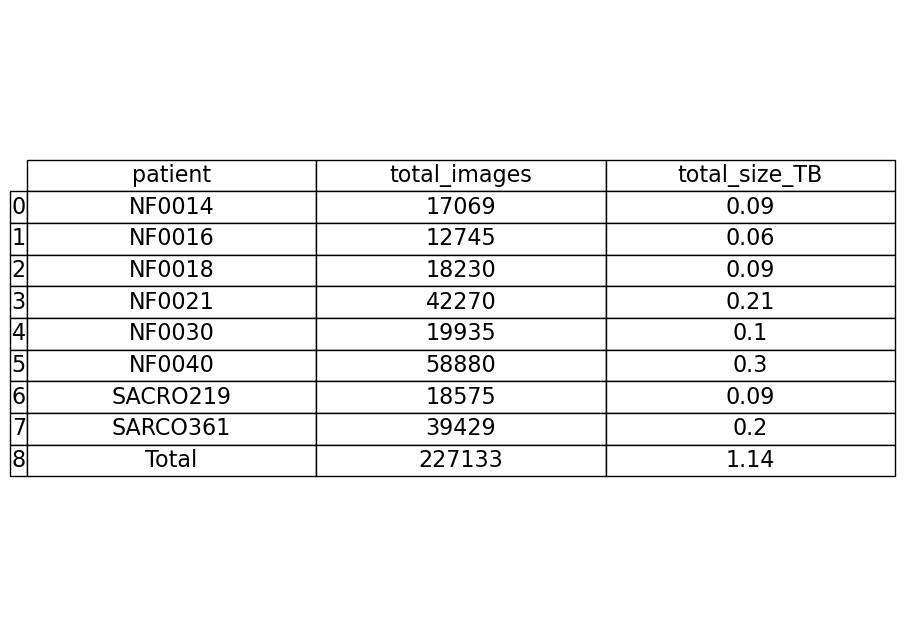

In [10]:
# render the df in markdown
if in_notebook:
    from IPython.display import Markdown, display

    display(Markdown(file_info_df_grouped.to_markdown(index=False)))
else:
    print(file_info_df_grouped.to_markdown(index=False))

# save the table as a png
png_figure_path = pathlib.Path(f"{root_dir}/figures/table2/figures/file_info_table.png")
png_figure_path.parent.mkdir(parents=True, exist_ok=True)
if in_notebook:
    import matplotlib.pyplot as plt
    from pandas.plotting import table

    fig, ax = plt.subplots(figsize=(8, 8))  # Set the size of the figure
    ax.axis("off")  # Hide the axes
    tbl = table(ax, file_info_df_grouped, loc="center", cellLoc="center")
    tbl.auto_set_font_size(False)  # Disable automatic font size
    tbl.set_fontsize(16)  # Set a fixed font size
    tbl.scale(1.4, 1.9)  # Scale the table to fit better
    plt.savefig(png_figure_path, bbox_inches="tight", dpi=300)